# <center>Gold price prediction and the selection of most significant features</center>

Gold price variation can be sensitive to many features such as global economy, international tension, epidemic or global pandemic, and so on. SPDR Gold Trust (GLD) exchange-traded fund (ETF) is a good indicator and tracker for the movement of gold price. Many efforts have been done by other scientists and researchers regarding this topic [1-7]. In this project, we are going to analysis the GLD price data, and try to predict future GLD prices, by exploring features which affect the price of gold more significantly.

### Data Collection, Wrangling, and Exploratory Analysis

Historical GLD price data were obtained from NYSE Arca delayed price in USD at yahoo.com [8]. The time period is from Nov 18, 2004 to Dec 19, 2020, including daily values except weekends and holidays.

In [1]:
# importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timezone, timedelta
import six
import sys
sys.modules['sklearn.externals.six'] = six
from pyramid.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"


e:\programdata\condaenv\springboard\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


We firstly loaded the data, followed by filling the missing values of weekends and holidays with previous day's values. Then we selected closing price as dependent variable for prediction.

In [2]:
# Load the csv data as pd.DataFrame, wrangle, and perform EDA
raw_data=pd.read_csv('..\\data\\raw\\GLD.csv', parse_dates=True, index_col='Date')
# Fill the missing values for weekends and holidays with previous valid values
filled_data=raw_data.resample('D').ffill()
filled_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-20,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-21,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200


In [3]:
# Check missing data: there is no missing data in the data set.
filled_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# Describe of the data set.
filled_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5.874000e+03
mean,112.887143,113.464137,112.280187,112.906845,112.906845,9.854389e+06
std,35.257236,35.376871,35.103591,35.248126,35.248126,7.159513e+06
min,41.029999,41.360001,41.020000,41.259998,41.259998,3.193000e+05
25%,89.720001,90.652500,89.160004,89.862499,89.862499,5.302275e+06
50%,118.494999,118.940002,117.980003,118.489998,118.489998,8.259950e+06
75%,133.040001,133.680000,132.345005,133.110001,133.110001,1.227280e+07
max,193.740005,194.449997,192.520004,193.889999,193.889999,9.380420e+07


Here we take Close price as dependent variable, and subset the Close column.

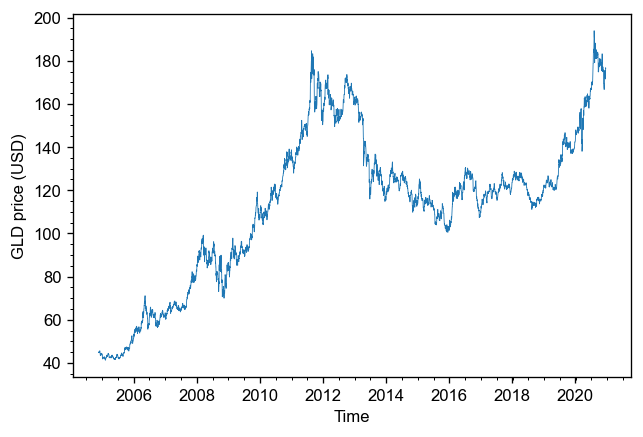

In [5]:
data=filled_data[['Close']]
fig, ax=plt.subplots(1, 1)
ax.plot(data, linewidth=0.5)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('GLD price (USD)')
plt.show()

### Modeling and Prediction

#### Internal Features

We would like to see if the close price is stationary, which means its probability distribution does not change over time [1]. We performed an Augmented Dicky-Fuller test on the close price. The p-value is 0.647 which is significantly larger than 0.05, indicating that the close price cannot be considered as stationary values. There are time-dependent structures in the close price values.

In [6]:
adfuller_result=adfuller(data['Close'])
print('ADF Statistic: \t{:.3f}'.format(adfuller_result[0]))
print('p-value: \t{:.3f}'.format(adfuller_result[1]))
print('Critical Values:')
for key, value in adfuller_result[4].items():
    print('\t{}: \t{:.3f}'.format(key, value))

ADF Statistic: 	-1.261
p-value: 	0.647
Critical Values:
	1%: 	-3.431
	5%: 	-2.862
	10%: 	-2.567


First, we are going to utilize a widely used statistical model for time series forecasting: AutoRegressive Integrated Moving Average (ARIMA) [9, 10], without any external features (exogenous variables). The number of autoregressive lags (p), order of differencing (d, which makes the data stationary), and number of moving average lags (q) will be optimized automatically by an auto_arima function.    

In [7]:
# Establish the auto arima model
arima_model=auto_arima(data.loc[:datetime(2020, 1, 1)],
                      seasonal=False,
                      start_p=1,
                      start_q=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=16080.915, BIC=16094.148, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0); AIC=16075.167, BIC=16095.016, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1); AIC=16075.302, BIC=16095.151, Fit time=0.054 seconds
Fit ARIMA: order=(2, 1, 0); AIC=16076.803, BIC=16103.268, Fit time=0.113 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.631 seconds


In [8]:
# Train the arima model with the data before 2010. 
# Note that the model never sees the data after 2010 before prediction
arima_model.fit(data.loc[:datetime(2020, 1, 1)])

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

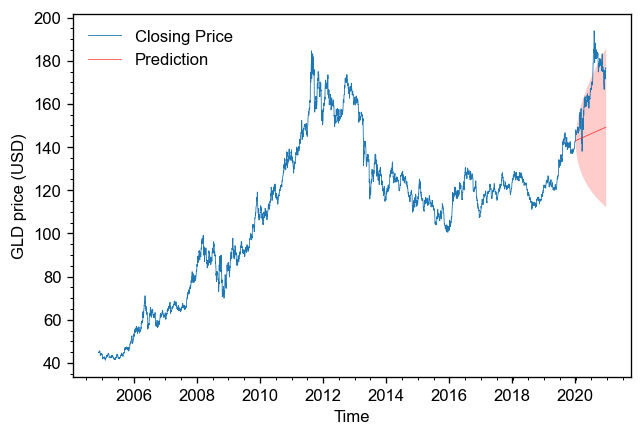

In [9]:
# Predict 2020 data
y_test, conf_int=arima_model.predict(n_periods=len(data.loc[datetime(2020, 1, 1):].index), 
                                                  return_conf_int=True,
                                                  alpha=0.05)
prediction_2020=pd.DataFrame(y_test, 
                             index=data.loc[datetime(2020, 1, 1):].index, 
                             columns=['Prediction'])
# Plot
fig, ax=plt.subplots(1, 1)
ax.plot(data.index, data['Close'], 
        label='Closing Price',
       linewidth=0.5)
ax.plot(prediction_2020, label='Prediction',
       alpha=0.7, 
       linewidth=0.5, c='r')
ax.fill_between(data.loc[datetime(2020, 1, 1):].index,
               [ele[1] for ele in conf_int],
               [ele[0] for ele in conf_int],
               alpha=0.2,
               color='r',
               linewidth=0.0)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('GLD price (USD)')
ax.legend(frameon=False)
plt.show()


The ARIMA model performs much better than linear regression model: the predicted 2020 GLD price trend is closer to the actual data. The 95% confidence interval includes most of the actual price data. This prediction approach is close to Aihui Ong's work [1]. 

Now it's time to look into the future. We are going to re-train this model with all-time data, and predict the GLD prices in 2021 and 2022.

In [10]:
arima_model=auto_arima(data,
                      seasonal=False,
                      start_p=1,
                      start_q=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
arima_model.fit(data)

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=17687.089, BIC=17700.445, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0); AIC=17685.130, BIC=17705.165, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 1); AIC=17685.194, BIC=17705.229, Fit time=0.057 seconds
Fit ARIMA: order=(2, 1, 0); AIC=17686.794, BIC=17713.507, Fit time=0.121 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.795 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

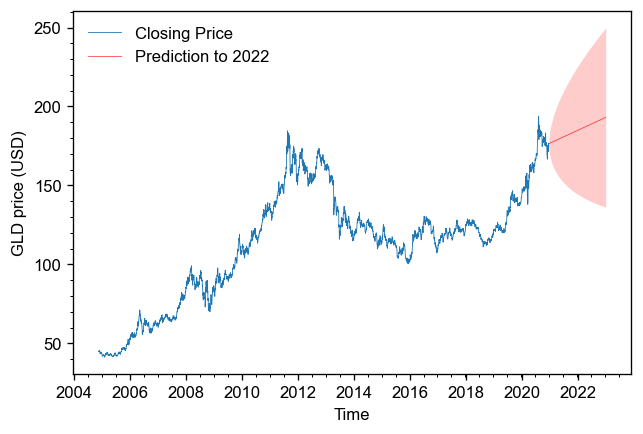

In [11]:
# From the end of the data set to the last day of 2022
future_time_frame=[data.iloc[-1].name.date()+timedelta(days=i) for i in range(1, 744)]
y_test, conf_int=arima_model.predict(n_periods=len(future_time_frame), 
                                                  return_conf_int=True,
                                                  alpha=0.05)
prediction_2022=pd.DataFrame(y_test, 
                             index=future_time_frame, 
                             columns=['Prediction'])
# Plot
fig, ax=plt.subplots(1, 1)
ax.plot(data.index, data['Close'], 
        label='Closing Price',
       linewidth=0.5)
ax.plot(prediction_2022, label='Prediction to 2022',
       alpha=0.7, 
       linewidth=0.5, c='r')
ax.fill_between(future_time_frame,
               [ele[1] for ele in conf_int],
               [ele[0] for ele in conf_int],
               alpha=0.2,
               color='r',
               linewidth=0.0)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('GLD price (USD)')
ax.legend(loc='upper left', frameon=False)
plt.show()

There is large probability that the GLD price is still going up in two years despite a recent dropping. So far the prediction work only used historical GLD price data, and sometimes the prediction can catch the moving momentum of price changes in a short time window. In order to improve the capacity of the model, we are going to consider external features as well. Because predicting future gold prices also needs to predict all kinds of future external features, and most of the features are hard to predict precisely. Therefore, this project is focusing on short-term prediction, such as one week, using the external features in the past. 

#### Internal and External Features

### Conclusion

### References
[1] Aihui Ong, Is Gold a Good Investment? Gold Price Prediction Using Machine Learning Techniques. https://www.springboard.com/blog/gold-price-prediction-using-machine-learning, 2020.

[2] Bhanu Yerra, Predicting Tomorrows Gold Price. Do We Have a Market Advantage? https://mlbhanuyerra.github.io/2019-10-12-Predicting-Tomorrows-Gold-Price/, 2019.

[3] ur Sami, I., and Khurum Nazir Junejo. Predicting Future Gold Rates using Machine Learning Approach. International Journal of Advanced Computer Science and Applications 8, no. 12: 92-99, 2017.

[4] Potoski, Megan. Predicting gold prices. CS229, Autumn, 2013.

[5] Ishan Shah, and Rekhit Pachanekar, Gold Price Prediction Using Machine Learning In Python. https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/, 2020  

[6] Bingol, Sakir, Safaa Sadik, Raland Matenggo, Hatim Badr Mouhcine, Jihad Albaf, Salma Chaabene, and Aaron Auta. Gold price prediction in times of 4inancial and geopolitical uncertainty: A machine learning approach. 2020.

[7] Zhu, Han-chao, and Wang, Dong. Predict the price of gold Based on Machine Learning Techniques. DEStech Transactions on Computer Science and Engineering mmsta, 2017.

[8] https://finance.yahoo.com/quote/GLD/history?p=GLD

[9] Box, George EP, Gwilym M. Jenkins, Gregory C. Reinsel, and Greta M. Ljung. Time series analysis: forecasting and control. John Wiley & Sons, 2015.

[10] Ariyo, Adebiyi A., Adewumi O. Adewumi, and Charles K. Ayo. "Stock price prediction using the ARIMA model." In 2014 UKSim-AMSS 16th International Conference on Computer Modelling and Simulation, pp. 106-112. IEEE, 2014.
